# Lorenz Differential Equation

In this notebook we will explore online parameter and state estimation for Lorenz attractor using an adaptive solver that automatically determines the step-size.

In [1]:
using LinearAlgebra, RxInfer, Plots, ExpectationApproximations,StableRNGs, ReactiveMP
import ExpectationApproximations: FromTo
include("delta_node_rules.jl")


# Introduction to Lorenz Differential Equation
The Lorenz differential equation is defined as the following system of equations 
$$\begin{aligned}
\mathrm{d}x &= \sigma (y - x) \\
\mathrm{d}y &= x (\rho - z) - y \\
\mathrm{d}z &= x y - \beta z \\
\end{aligned}$$
where $\sigma$, $\rho$ and $\beta$ are the parameters.

In [77]:
function lorenz_attractor(ϕ, θ, t)
    σ,ρ,β = θ
    x,y,z = ϕ

    dx = σ*(y - x)
    dy = x*(ρ -z) - y 
    dz = x*y - β*z 

    return [dx,dy,dz]
end


fitzhugh_nagumo_attractor (generic function with 1 method)

# Adaptive Solvers
Some of the numerical solvers allow time step $dt$ to be estimated adaptively while solving the system of equations. In this notebook, we will use Runge–Kutta–Fehlberg (RKF) method. RKF45 method is a method of order $\mathcal{O}(n^4)$ with an error estimate of order $\mathcal{O}(n^5)$. The main idea is to simulatenously solve different order solutions and track the error between these solutions. In RKF45, we solve with 5th order and 4th order solvers. The next function defines this approximation by using the specified Buther tableau. Higher order methods are possible with a variety of Butcher tableau. 

In [3]:
function rkf45_step(f::Function, x, θ, t, dt; tol=1e-6, safety=0.9)
    # Butcher tableau coefficients for RKF45
    a21 = 1/4
    a31, a32 = 3/32, 9/32
    a41, a42, a43 = 1932/2197, -7200/2197, 7296/2197
    a51, a52, a53, a54 = 439/216, -8, 3680/513, -845/4104
    a61, a62, a63, a64, a65 = -8/27, 2, -3544/2565, 1859/4104, -11/40
    
    # Coefficients for 4th order solution
    b41, b42, b43, b44, b45 = 25/216, 0, 1408/2565, 2197/4104, -1/5
    
    # Coefficients for 5th order solution
    b51, b52, b53, b54, b55, b56 = 16/135, 0, 6656/12825, 28561/56430, -9/50, 2/55
    
    # Error estimation coefficients (difference between 5th and 4th order solutions)
    e1 = b51 - b41
    e2 = b52 - b42
    e3 = b53 - b43
    e4 = b54 - b44
    e5 = b55 - b45
    e6 = b56 - 0     # b46 is 0 since k6 is not used in the 4th order solution
    
    # Compute the six stages
    k1 = f(x, θ, t)
    k2 = f(x + dt*a21*k1, θ, t + dt/4)
    k3 = f(x + dt*(a31*k1 + a32*k2), θ, t + 3dt/8)
    k4 = f(x + dt*(a41*k1 + a42*k2 + a43*k3), θ, t + 12dt/13)
    k5 = f(x + dt*(a51*k1 + a52*k2 + a53*k3 + a54*k4), θ, t + dt)
    k6 = f(x + dt*(a61*k1 + a62*k2 + a63*k3 + a64*k4 + a65*k5), θ, t + dt/2)
    
    # 4th order solution
    x4 = x + dt*(b41*k1 + b43*k3 + b44*k4 + b45*k5)
    
    # 5th order solution
    x5 = x + dt*(b51*k1 + b53*k3 + b54*k4 + b55*k5 + b56*k6)
    
    # Error estimation
    err = norm(x5 - x4)
    err = max(err, eps())
    if err >= tol
        dt_next = dt * safety * (tol/err)^(1/5)
    else
        dt_next = dt * safety * (tol/err)^(1/4)
    end

    return clamp.(x5, -100, 100), dt_next
end


rkf45_step (generic function with 1 method)

Next, we will define some auxiliary functions that are needed for inference and data generation. These functions mainly serve as approximations of the integral of the differential equation in $dt$ interval. First function is a wrapper. The second function transforms the tuple output of the integrator to a vector for further processing with RxInfer. The third function, introduces exponential transformations of the parameters and the time step of the integrator so that we can model them in the log domain. 

In [22]:

lorenz_nonlinearity_data(x, θ, t, dt)  = rkf45_step(lorenz_attractor, x, θ, t, dt)
lorenz_nonlinearity(x, θ, t, dt) = vcat(lorenz_nonlinearity_data(x,θ,t,dt)...)
lorenz_nonlinearity_logdt(x,logθ,t,logdt) = lorenz_nonlinearity(x,exp.(logθ),t,exp(logdt))

lorenz_nonlinearity_logdt (generic function with 2 methods)

# Data Generation

First we simulate the Lorenz system with known parameters. Then, we corrupt the states with noise. Then, we select a random set of indices as points of measurement at irregularly sampled interval. 

In [58]:
function generate_data(parameters, tspan, start; Σ = 2diageye(3), t = 0, dt = 0.001, rng = StableRNG(42))
    solution = []
    ts = []
    dts = []
    state = start
    tstart, tend = tspan

    push!(ts, t)
    push!(dts, dt)
    push!(solution, state)
    
    while t <= tend
        state, dt_new = lorenz_nonlinearity_data(state, parameters, t, dt)
        t += dt_new
        dt = dt_new
        push!(solution , state)
        push!(dts, dt)
        push!(ts, t)
    end


    observations = [sol + sqrt(Σ)*randn(rng, 3) for sol in solution]

    return solution, observations, dts, ts
end

start = [1.0, 0.0, 0.0]
tspan = (0.0, 800.0)
parameters = [10.0,29.0,2.66]
Nmeasurements = 4000
Σ = 5diageye(3)
rng = StableRNG(42)


simulation, observations,dts, ts = generate_data(parameters,  tspan, start, Σ = Σ);
discrete_observations = Vector{Union{Missing, Vector{Float64}}}(missing, length(observations))
data_indices = rand(rng, 1:length(observations), Nmeasurements)
discrete_observations[data_indices] = observations[data_indices];

println("Length of simulation: ", length(simulation))
println("Number of observations: ", Nmeasurements)




Length of simulation: 59464
Number of observations: 4000


# RxInfer model definition

Now we are ready to specify the RxInfer model that we are going to use to identify the Lorenz system. Since we are interested in online estimation and we do not know the length of the observations in advence, we will create a "one-time-segment" graph. The model will accept statistics from previous time steps and other relevant hyper-parameters such as $A$ and $\Sigma$ matrices. We assume Gaussian priors for the parameters and the discretization intervals in log-domain. The function `lorenz_nonlinearity_logdt` will transform the parameters and the $dt$ to their respective domains. Since `lorenz_nonlinearity_logdt` outputs also the next time step, the state `x` defined below, will have extra dimension that records $\log \mathrm{d}t$. We need to extract the first three components from the output of this function as observations will be noisy realizations of those components. The matrix $A$ will allow us to do this. The matrix $\Sigma$ is the noise covariance. 

In [59]:
@model function lorenz_model(Σ, mθ,Vθ, mx, Vx, obs, A, log_dt_m, log_dt_V)
    logθ ~ MvNormalMeanCovariance(mθ, Vθ)
    xprev ~ MvNormalMeanCovariance(mx, Vx)
    log_dt ~ NormalMeanVariance(log_dt_m, log_dt_V)
    x := lorenz_nonlinearity_logdt(xprev, logθ, 0.0, log_dt) 
    obs ~ MvNormalMeanCovariance(A*x, Σ)
end

# Meta specification
Due to non-linearity induced by `lorenz_nonlinearity_logdt`, we will resort to approximation methods around this function. For that purpose we will utilize Generalized Unscented Transform, which is an improved version of Unscented Transform. We will specify the Generalized Unscented Transform using `@meta` macro. 

In [60]:
@meta function lorenz_meta()
    lorenz_nonlinearity_logdt() -> DeltaMeta(
        method = GenUnscented{FromTo(Multivariate, Multivariate)}(7, (4,)), 
        inverse = nothing
    )
end

lorenz_meta (generic function with 1 method)

# Autoupdates and initializations 
Because we are updating the parameters and states in an online fashion, we need to define how these updates will be defined on the parameters of the distributions. We will specify the form of these updates with `@initialization` macro. Since `x` encapsulates both states and $\log \mathrm{d}t$, we need to specify how to update the corresponding distributions. For the states, we pass the mean and covariance of all the dimensions except the last dimension of the posterior distribution to the next step as the prior statistics. For $\log \mathrm{d}t $, things are a bit more complicated. The reason is as follows. Non-linear node returns $\mathrm{d}t$, however the update needs to happen in log domain. Luckily, we can easily perform this update if we recognize that $\mathrm{d}t$ will be log-Normal distributed as it is defined as the exponential transform of a Gaussian distributed random variable $\log \mathrm{d}t$. Due to this we can take the statistics of the log-Normally distributed $\mathrm{d}t$ from the last elements of $x$ and updated them in the log domain with `custom_mean_cov_dt` function.

In [70]:

function custom_mean_cov_x(q)
    mx = mean(q)[1:end-1]
    Vx = cov(q)[1:end-1, 1:end-1]
    return mx, Vx
end
function custom_mean_cov_dt(q)
    mx = mean(q)[end] + 1e-12 ## in case of zero division
    Vx = cov(q)[end,end]

    V = log(abs(Vx / mx^2  + 1))
    m = log(abs(mx)) - V/2
    return m, V
end
update = @autoupdates begin
    mx, Vx =  custom_mean_cov_x(q(x))
    log_dt_m, log_dt_V = custom_mean_cov_dt(q(x))
    mθ, Vθ = mean_cov(q(logθ))
end


@initialization function init()
    q(x) = MvNormalMeanCovariance([start;0.01], 1e-4*diageye(4))
    q(logθ) = MvNormalMeanCovariance(ones(3), diageye(3))
end

#Mean and variance of log-normal distribution
function log_normal_stats(m,v)
    return exp(m + v/2), (exp(v) -1)*(exp(2*m + v))
end


log_normal_stats (generic function with 1 method)

# Inference

We are now ready to call the `infer` function. For that we pass the `discrete_observations` containing `missing` and actual values as data, alongside the `model`, `meta`, `autoupdates` and `initialization` functions we have defined.

In [71]:

A = [1 0 0 0; 0 1 0 0; 0 0 1 0]

res = infer(
    model = lorenz_model(Σ = Σ, A = A),
    data = (obs =discrete_observations,),
    meta = lorenz_meta(),
    keephistory = length(discrete_observations),
    autoupdates = update,
    initialization = init(),
)

RxInferenceEngine:
  Posteriors stream    | enabled for (anonymous_var_graphppl, logθ, log_dt, xprev, x)
  Free Energy stream   | disabled
  Posteriors history   | available for (anonymous_var_graphppl, logθ, log_dt, xprev, x)
  Free Energy history  | unavailable
  Enabled events       | [  ]

In [72]:

logθ_posteriors =  res.history[:logθ]
stat_tuples = map(d -> log_normal_stats.(mean(d),var(d)), logθ_posteriors)
ms = map(t -> [t[1][1], t[2][1], t[3][1]], stat_tuples)
vs = map(t -> [t[1][2], t[2][2], t[3][2]], stat_tuples)
;

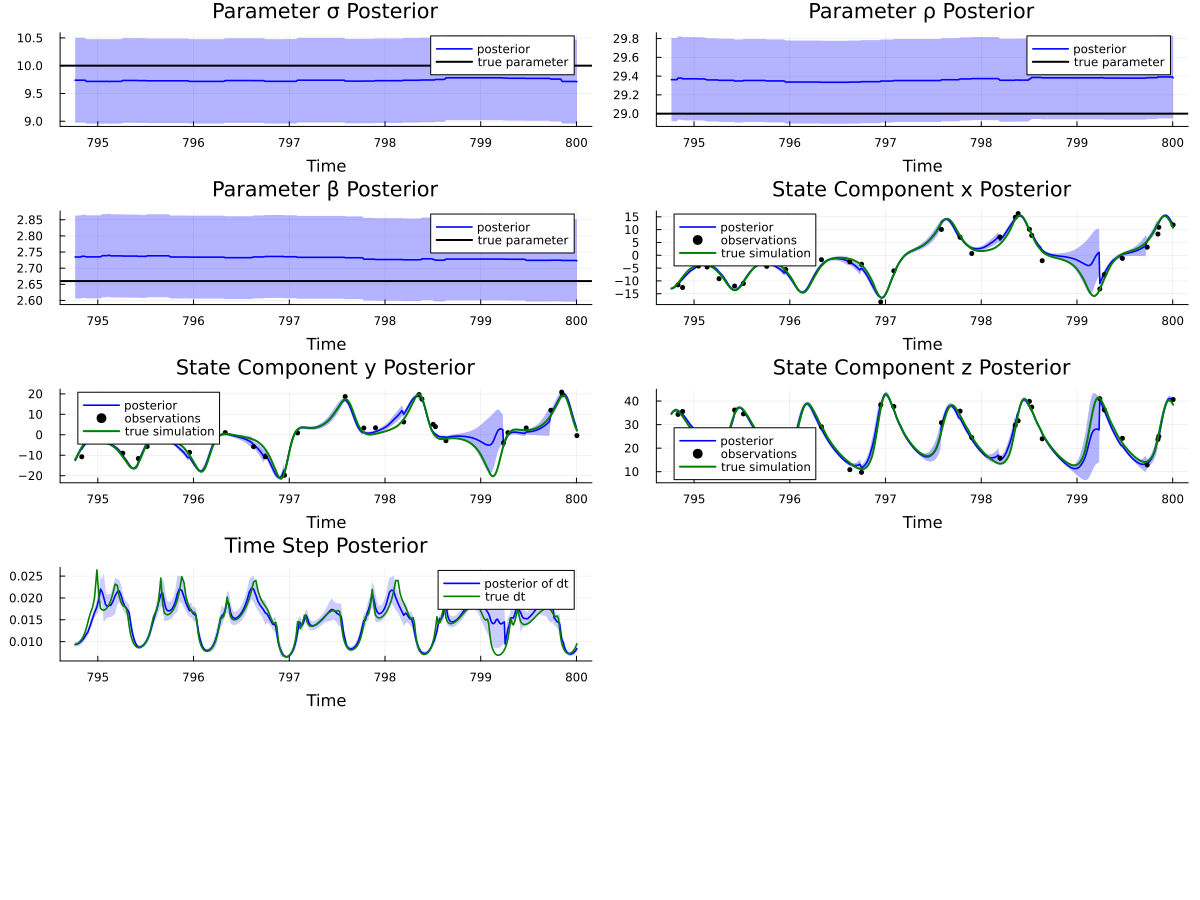

In [73]:

# Create a comprehensive subplot layout with all parameters and states
# Parameter plots
param_names = ["σ", "ρ", "β"]
param_plots = []

from_param = length(ms)-400
skip_param = 1
to_param = length(ms)

for i in 1:3
    p = plot(
        ts[from_param:skip_param:to_param], 
        getindex.(ms,i)[from_param:skip_param:to_param], 
        ribbon = sqrt.(getindex.(vs,i)[from_param:skip_param:to_param]), 
        fillalpha = 0.3, 
        linewidth = 1.6, 
        color = :blue, 
        label = "posterior",
        title = "Parameter $(param_names[i]) Posterior",
        xlabel = "Time"
    )
    hline!(p, [parameters[i]], linewidth = 2, linecolor = :black, label = "true parameter")
    push!(param_plots, p)
end

# State component plots
state_component_names = ["x", "y", "z"]
state_plots = []

from_state = length(ts)-400
skip_state = 1
to_state = length(ts)

states_posterior = res.history[:x]
m_states = mean.(states_posterior)
v_states = var.(states_posterior)

for i in 1:3
    p = plot(
        ts[from_state:skip_state:to_state],
        getindex.(m_states,i)[from_state:skip_state:to_state],
        ribbon = sqrt.(getindex.(v_states,i)[from_state:skip_state:to_state]), 
        fillalpha = 0.3, 
        linewidth = 1.6, 
        color = :blue,
        label = "posterior",
        title = "State Component $(state_component_names[i]) Posterior",
        xlabel = "Time"
    )
    
    # Filter non-missing observations and their corresponding timestamps
    valid_indices = findall(j -> !ismissing(discrete_observations[j]), from_state:skip_state:to_state)
    valid_ts = ts[from_state:skip_state:to_state][valid_indices]
    valid_obs = discrete_observations[from_state:skip_state:to_state][valid_indices]
    
    # Plot only non-missing observations
    scatter!(p, valid_ts, [obs[i] for obs in valid_obs], color = :black, ms = 2.8, label = "observations")
    plot!(p, ts[from_state:skip_state:to_state], [sim[i] for sim in simulation[from_state:skip_state:to_state]], 
          color = :green, linewidth = 2, label = "true simulation")
    
    push!(state_plots, p)
end

# Time step posterior plot
logdt_posteriors = res.history[:log_dt]
stat_tuples = map(d -> log_normal_stats(mean(d),var(d)), logdt_posteriors)
m_logdt = map(t -> t[1], stat_tuples)
v_logdt = map(t -> t[2], stat_tuples)
from_dt = length(ts)-400
to_dt = length(m_logdt)
skip_dt = 1

dt_plot = plot(
    ts[from_dt:skip_dt:to_dt], 
    m_logdt[from_dt:skip_dt:to_dt], 
    ribbon = sqrt.(v_logdt[from_dt:skip_dt:to_dt]), 
    fillalpha = 0.2, 
    linewidth = 1.6, 
    color = :blue,
    label = "posterior of dt",
    title = "Time Step Posterior",
    xlabel = "Time"
)

plot!(dt_plot, ts[from_dt:skip_dt:to_dt], [dts[i] for i in from_dt:skip_dt:to_dt], linewidth = 1.6,color = :green, label = "true dt")

# Combine all plots into a single figure with layout
combined_plot = plot(
    param_plots[1], param_plots[2], param_plots[3],
    state_plots[1], state_plots[2], state_plots[3],
    dt_plot,
    layout = (6, 2), 
    size = (1200, 900), 
    legend = true
)

display(combined_plot)



# BONUS: Same methodology applied to Fitz-Hugh-Nagumo attractor

In [224]:
function fitzhugh_nagumo_attractor(ϕ, θ, t)
    v,w = ϕ
    l,τinv,a,b = θ
    dv = v - 0.33*v^3 -w + l
    dw = τinv*(v +  a - b*w)

    return [dv,dw]
end

fitzhugh_nagumo_nonlinearity_data(x, θ, t, dt)  = rkf45_step(fitzhugh_nagumo_attractor, x, θ, t, dt)
fitzhugh_nagumo_nonlinearity(x, θ, t, dt) = vcat(fitzhugh_nagumo_nonlinearity_data(x,θ,t,dt)...)
fitzhugh_nagumo_nonlinearity_logdt(x,logθ,t,logdt) = fitzhugh_nagumo_nonlinearity(x,exp.(logθ),t,exp(logdt))

fitzhugh_nagumo_nonlinearity_logdt (generic function with 1 method)

In [225]:
function generate_data_fitzhugh_nagumo(parameters, tspan, start; Σ = 2diageye(2), t = 0, dt = 0.001, rng = StableRNG(42))
    solution = []
    ts = []
    dts = []
    state = start
    tstart, tend = tspan

    push!(ts, t)
    push!(dts, dt)
    push!(solution, state)
    
    while t <= tend
        state, dt_new = fitzhugh_nagumo_nonlinearity_data(state, parameters, t, dt)
        t += dt_new
        dt = dt_new
        push!(solution , state)
        push!(dts, dt)
        push!(ts, t)
    end


    observations = [sol + sqrt(Σ)*randn(rng, 2) for sol in solution]

    return solution, observations, dts, ts
end

start = [1.0, 1.0]
tspan = (0.0, 40.0)
parameters = [0.7,0.8,0.08,0.5]
Nmeasurements = 200
Σ = 0.04diageye(2)
rng = StableRNG(42)


simulation, observations,dts, ts = generate_data_fitzhugh_nagumo(parameters,  tspan, start, Σ = Σ);
discrete_observations = Vector{Union{Missing, Vector{Float64}}}(missing, length(observations))
data_indices = rand(rng, 1:length(observations),Nmeasurements)
discrete_observations[data_indices] = observations[data_indices];

println("Length of simulation: ", length(simulation))
# println("Number of observations: ", Nmeasurements)

Length of simulation: 172


In [226]:
@model function fitzhugh_nagumo_model(Σ, mθ,Vθ, mx, Vx, obs, A, log_dt_m, log_dt_V)
    logθ ~ MvNormalMeanCovariance(mθ, Vθ)
    xprev ~ MvNormalMeanCovariance(mx, Vx)
    log_dt ~ NormalMeanVariance(log_dt_m, log_dt_V)
    x := fitzhugh_nagumo_nonlinearity_logdt(xprev, logθ, 0.0, log_dt) 
    obs ~ MvNormalMeanCovariance(A*x, Σ)
end

@meta function fitzhugh_nagumo_meta()
    fitzhugh_nagumo_nonlinearity_logdt() -> DeltaMeta(
        method = GenUnscented{FromTo(Multivariate, Multivariate)}(7, (3,)), 
        inverse = nothing
    )
end


@initialization function init_fitzhugh_nagumo()
    q(x) = MvNormalMeanCovariance([start;0.01], 1e-6*diageye(3))
    q(logθ) = MvNormalMeanCovariance([0, 0,0,0], 5diageye(4))
end


init_fitzhugh_nagumo (generic function with 1 method)

In [227]:
A = [1 0 0 ; 0 1 0 ]

res = infer(
    model = fitzhugh_nagumo_model(Σ = Σ, A = A),
    data = (obs =discrete_observations,),
    meta = fitzhugh_nagumo_meta(),
    keephistory = length(discrete_observations),
    autoupdates = update,
    initialization = init_fitzhugh_nagumo(),
)

RxInferenceEngine:
  Posteriors stream    | enabled for (anonymous_var_graphppl, logθ, log_dt, xprev, x)
  Free Energy stream   | disabled
  Posteriors history   | available for (anonymous_var_graphppl, logθ, log_dt, xprev, x)
  Free Energy history  | unavailable
  Enabled events       | [  ]

In [228]:

logθ_posteriors =  res.history[:logθ]
stat_tuples = map(d -> log_normal_stats.(mean(d),var(d)), logθ_posteriors)

ms = map(t -> [t[1][1], t[2][1], t[3][1], t[4][1]], stat_tuples)
vs = map(t -> [t[1][2], t[2][2], t[3][2], t[4][2]], stat_tuples)
;

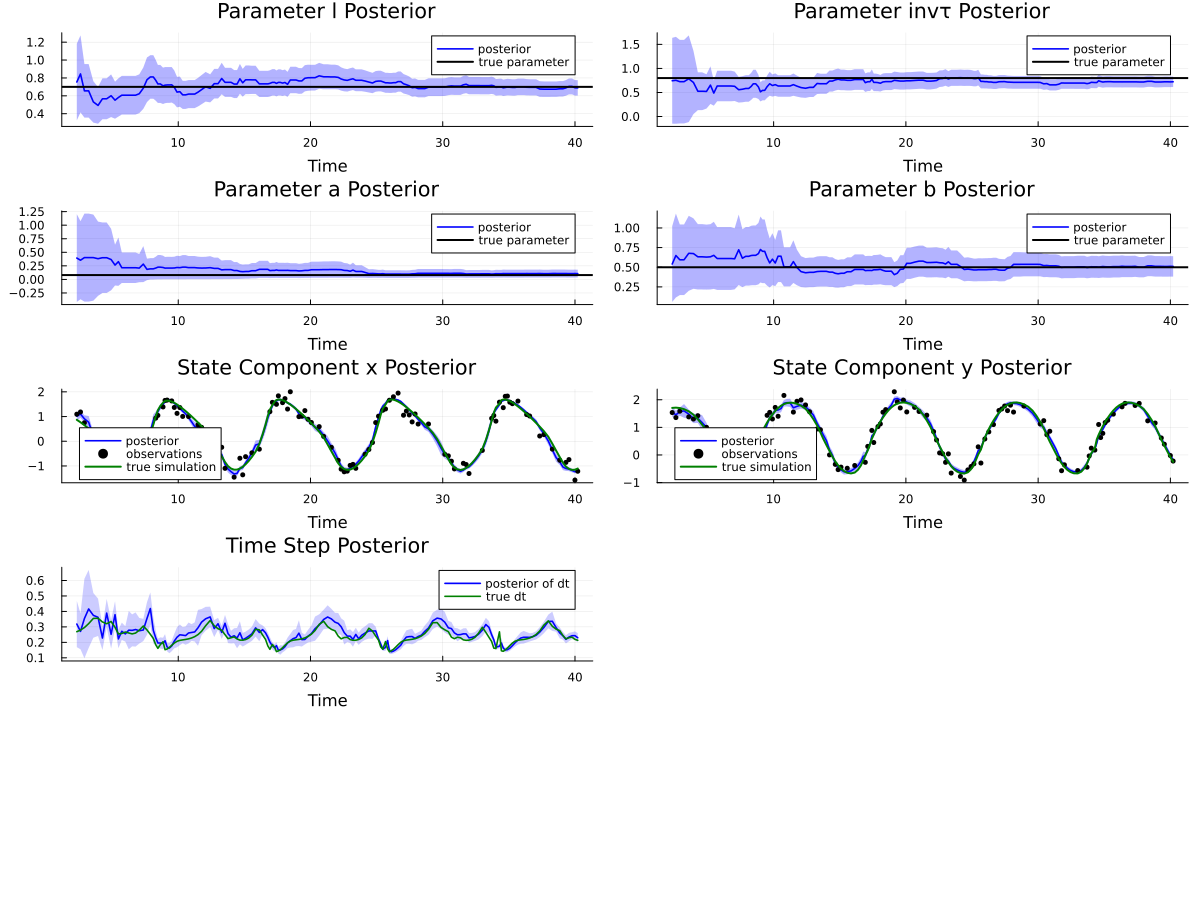

In [229]:

# Create a comprehensive subplot layout with all parameters and states
# Parameter plots
param_names = ["l", "invτ", "a", "b"]
param_plots = []

from_param = 10
skip_param = 1
to_param = length(ms)

for i in 1:4
    p = plot(
        ts[from_param:skip_param:to_param], 
        getindex.(ms,i)[from_param:skip_param:to_param], 
        ribbon = sqrt.(getindex.(vs,i)[from_param:skip_param:to_param]), 
        fillalpha = 0.3, 
        linewidth = 1.6, 
        color = :blue, 
        label = "posterior",
        title = "Parameter $(param_names[i]) Posterior",
        xlabel = "Time"
    )
    hline!(p, [parameters[i]], linewidth = 2, linecolor = :black, label = "true parameter")
    push!(param_plots, p)
end

# State component plots
state_component_names = ["x", "y", "z"]
state_plots = []

from_state = 10
skip_state = 1
to_state = length(ts)

states_posterior = res.history[:x]
m_states = mean.(states_posterior)
v_states = var.(states_posterior)

for i in 1:2
    p = plot(
        ts[from_state:skip_state:to_state],
        getindex.(m_states,i)[from_state:skip_state:to_state],
        ribbon = sqrt.(getindex.(v_states,i)[from_state:skip_state:to_state]), 
        fillalpha = 0.3, 
        linewidth = 1.6, 
        color = :blue,
        label = "posterior",
        title = "State Component $(state_component_names[i]) Posterior",
        xlabel = "Time"
    )
    
    # Filter non-missing observations and their corresponding timestamps
    valid_indices = findall(j -> !ismissing(discrete_observations[j]), from_state:skip_state:to_state)
    valid_ts = ts[from_state:skip_state:to_state][valid_indices]
    valid_obs = discrete_observations[from_state:skip_state:to_state][valid_indices]
    
    # Plot only non-missing observations
    scatter!(p, valid_ts, [obs[i] for obs in valid_obs], color = :black, ms = 2.8, label = "observations")
    plot!(p, ts[from_state:skip_state:to_state], [sim[i] for sim in simulation[from_state:skip_state:to_state]], 
          color = :green, linewidth = 2, label = "true simulation")
    
    push!(state_plots, p)
end

# Time step posterior plot
logdt_posteriors = res.history[:log_dt]
stat_tuples = map(d -> log_normal_stats(mean(d),var(d)), logdt_posteriors)
m_logdt = map(t -> t[1], stat_tuples)
v_logdt = map(t -> t[2], stat_tuples)
from_dt = 10
to_dt = length(m_logdt)
skip_dt = 1

dt_plot = plot(
    ts[from_dt:skip_dt:to_dt], 
    m_logdt[from_dt:skip_dt:to_dt], 
    ribbon = sqrt.(v_logdt[from_dt:skip_dt:to_dt]), 
    fillalpha = 0.2, 
    linewidth = 1.6, 
    color = :blue,
    label = "posterior of dt",
    title = "Time Step Posterior",
    xlabel = "Time"
)

plot!(dt_plot, ts[from_dt:skip_dt:to_dt], [dts[i] for i in from_dt:skip_dt:to_dt], linewidth = 1.6,color = :green, label = "true dt")

# Combine all plots into a single figure with layout
combined_plot = plot(
    param_plots[1], param_plots[2], param_plots[3], param_plots[4],
    state_plots[1], state_plots[2],
    dt_plot,
    layout = (6, 2), 
    size = (1200, 900), 
    legend = true
)

display(combined_plot)